# Adversarial Image Captioning Attack

**Estimated Total Runtime on CPU: 12-20 hours**

This notebook implements two adversarial attack methods:
1. **Differential Evolution (DE)**: Gradient-free optimization (~10-16 hours)
2. **Projected Gradient Descent (PGD)**: Gradient-based attack (~2-4 hours)

### Import Libraries, Set Seeds, and Select GPU

In [1]:
# Standard libraries
import json
import os

# Third party packages
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, ViTImageProcessor, VisionEncoderDecoderModel

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


### Load COCO Mini Dataset

In [3]:
# Download dataset
data_path = kagglehub.dataset_download(
    "nagasai524/mini-coco2014-dataset-for-image-captioning")

Using Colab cache for faster access to the 'mini-coco2014-dataset-for-image-captioning' dataset.


In [4]:
def load_captions(dataset_path):
    """Load image_id -> list of captions mapping from captions.json."""
    captions_path = os.path.join(dataset_path, "captions.json")
    with open(captions_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"] if isinstance(data, dict) else data

    captions = {}
    for ann in annotations:
        img_id = ann["image_id"]
        captions.setdefault(img_id, []).append(ann["caption"])
    return captions

In [5]:
def find_image_folder(dataset_path, ext=".jpg"):
    """Find first folder under dataset_path that contains image files."""
    for root, _, files in os.walk(dataset_path):
        if any(f.lower().endswith(ext) for f in files):
            return root
    raise RuntimeError(f"No image folder with *{ext} found under {dataset_path}")

In [6]:
captions = load_captions(data_path)
img_folder = find_image_folder(data_path)
img_ids = sorted(captions.keys())

print(f"Dataset loaded, {len(img_ids)} images with captions")

Dataset loaded, 18783 images with captions


### Image Loading Helper

In [7]:
def get_image(idx):
    """Load image and its captions by index in img_ids."""
    img_id = img_ids[idx]

    # Try common filename patterns
    candidates = [
        os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg"),
        os.path.join(img_folder, f"{img_id}.jpg"),
    ]

    for img_path in candidates:
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            return img, captions[img_id]

    raise FileNotFoundError(f"No image file found for image_id {img_id}")


### Visual Inspection of a Sample Image

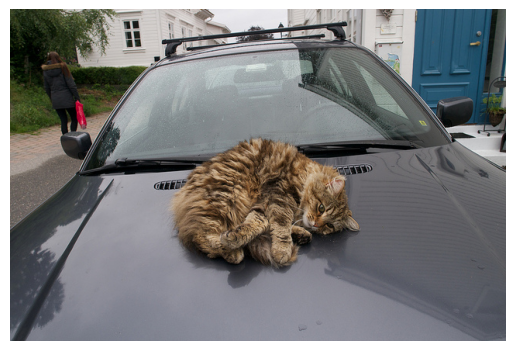

Image index: 6000, image_id: 190360
Ground truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [8]:
# Choose an image to show
idx = 6000

img, caps = get_image(idx)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("Ground truth captions:")
for cap in caps:
    print(f"  - {cap}")


### Load ViT-GPT2

In [9]:
model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(
    model_name,
    attn_implementation="eager").to(device)

feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.eval()

print(f"Loaded model: {model_name}")
print(f"Decoder attention implementation: {model.config.decoder._attn_implementation}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

Loaded model: nlpconnect/vit-gpt2-image-captioning
Decoder attention implementation: eager


In [10]:
@torch.no_grad()
def generate_caption_and_attention(img, max_length=16):
    """
    Generate a caption for a PIL image and return:
    - caption (str)
    - cross_attentions (list of tensors)
    - encoder_hidden_states (tensor)
    """
    # Image -> pixel_values
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Encode image
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state  # [1, 197, hidden_dim]

    # Generate caption ids
    generated_ids = model.generate(
        pixel_values,
        max_length=max_length,
        num_beams=1)

    # Run decoder once over full sequence to get cross-attentions
    decoder_outputs = model.decoder(
        input_ids=generated_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False)

    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return caption, decoder_outputs.cross_attentions, encoder_hidden_states


In [11]:
def aggregate_cross_attention(cross_attentions, img_size, patch_size=14):
    """
    Aggregate cross-attention over heads and tokens into a 2D heatmap
    in image resolution (sentence-based aggregation).

    cross_attentions: list of tensors, each [1, num_heads, tgt_len, src_len]
                      src_len = 1 (CLS) + patch_size^2
    img_size: (width, height) of the original image
    """
    # Take last decoder layer (most informative)
    last_layer = cross_attentions[-1]          # [1, num_heads, tgt_len, src_len]
    last_layer = last_layer.squeeze(0)         # [num_heads, tgt_len, src_len]

    # Average over heads and decoder tokens
    avg_over_heads = last_layer.mean(dim=0)    # [tgt_len, src_len]
    avg_over_tokens = avg_over_heads.mean(dim=0)  # [src_len]

    # Drop CLS token and keep only patch tokens
    patch_attention = avg_over_tokens[1:]      # [patch_size^2]

    # Reshape to patch grid
    attention_map = patch_attention.reshape(patch_size, patch_size).cpu().numpy()

    # Normalize to [0, 1]
    attention_map -= attention_map.min()
    denom = attention_map.max() if attention_map.max() > 0 else 1e-8
    attention_map /= denom

    # Upsample to original image size
    w, h = img_size
    attn_img = Image.fromarray((attention_map * 255).astype(np.uint8))
    attn_resized = attn_img.resize((w, h), resample=Image.BICUBIC)

    return np.array(attn_resized) / 255.0

In [12]:
def show_image_and_attention(img, caption, attention_heatmap):
    """Plot original image, attention heatmap, and overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1) Original image
    axes[0].imshow(img)
    axes[0].set_title(f"Original image\nCaption: '{caption}'", fontsize=10)
    axes[0].axis("off")

    # 2) Heatmap only
    axes[1].imshow(attention_heatmap, cmap="hot")
    axes[1].set_title("Cross-attention heatmap\n(sentence-based)", fontsize=10)
    axes[1].axis("off")

    # 3) Overlay
    axes[2].imshow(img)
    axes[2].imshow(attention_heatmap, cmap="hot", alpha=0.5)
    axes[2].set_title("Attention overlay\n(red = high attention)", fontsize=10)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


### Load BLIP and add caption generation function

In [13]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load BLIP
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)
blip_model.eval()

print("BLIP model loaded!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

BLIP model loaded!


In [14]:
@torch.no_grad()
def generate_blip_caption(img, max_length=20):
    """Generate caption using BLIP model"""
    inputs = blip_processor(img, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs, max_length=max_length, num_beams=1)
    return blip_processor.decode(out[0], skip_special_tokens=True)

### Example: Pick an Image, Get Caption and Attention and Visualize

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


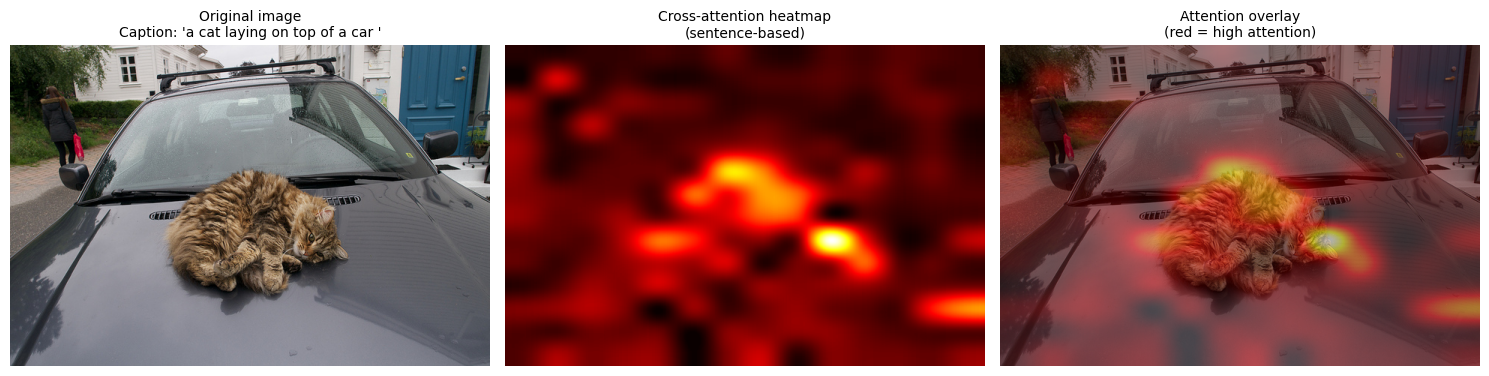

Image index: 6000, image_id: 190360

Ground-truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [15]:
img, gt_caps = get_image(idx)

caption, cross_attentions, _ = generate_caption_and_attention(img)
attention_heatmap = aggregate_cross_attention(cross_attentions, img.size)

show_image_and_attention(img, caption, attention_heatmap)

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("\nGround-truth captions:")
for cap in gt_caps:
    print(f"  - {cap}")

## Attack Pipeline

### Get the Candidate Mask

In [16]:
def get_topk_candidate_pixels(attention_heatmap, k):
    """
    Select top-k pixels with highest attention as candidate region.
    Returns list of (y, x) indices.
    """
    flat = attention_heatmap.flatten()
    k = min(k, flat.size)
    idxs = np.argpartition(flat, -k)[-k:]
    ys, xs = np.unravel_index(idxs, attention_heatmap.shape)
    return list(zip(ys, xs))


def show_candidate_region(img, attention_heatmap, candidate_pixels):
    """
    Visualize original image and candidate region (pixels we may perturb).
    """
    mask = np.zeros(attention_heatmap.shape, dtype=bool)
    for y, x in candidate_pixels:
        mask[y, x] = True

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original image")
    axes[0].axis("off")

    # Candidate overlay
    axes[1].imshow(img)
    axes[1].imshow(mask, cmap="Reds", alpha=0.6)
    axes[1].set_title("Candidate region (pixels we may perturb)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
ATTACK_IDX = idx

# Load image
base_img, gt_caps = get_image(ATTACK_IDX)

# Get base captions from BOTH models
base_caption_vit, cross_attentions, _ = generate_caption_and_attention(base_img, max_length=16)
base_caption_blip = generate_blip_caption(base_img, max_length=16)

# Aggregate attention (sentence-based)
attention_heatmap = aggregate_cross_attention(cross_attentions, base_img.size)

# Select candidate pixels - REDUCED for better optimization
TOPK_PIXELS = 1000
candidate_pixels = get_topk_candidate_pixels(attention_heatmap, k=TOPK_PIXELS)

print(f"Attack Setup:")
print(f"  Image index: {ATTACK_IDX}")
print(f"  ViT-GPT2 caption: '{base_caption_vit}'")
print(f"  BLIP caption: '{base_caption_blip}'")
print(f"  Candidate pixels: {len(candidate_pixels)}")

# Visualize candidate region
show_candidate_region(base_img, attention_heatmap, candidate_pixels)

In [35]:
def image_to_array(img):
    """Convert PIL image to uint8 numpy array of shape (H, W, 3)."""
    return np.array(img).astype(np.uint8)


def array_to_image(arr):
    """Convert numpy array (H, W, 3) back to PIL image."""
    return Image.fromarray(arr.astype(np.uint8))


def apply_perturbation(base_array, delta_vec, candidate_pixels):
    """
    Apply a perturbation vector to the candidate pixels of an image.

    base_array: numpy array (H, W, 3), uint8
    delta_vec: 1D numpy array of length 3 * len(candidate_pixels)
               [dR1, dG1, dB1, dR2, dG2, dB2, ...]
    candidate_pixels: list of (y, x) positions
    """
    H, W, C = base_array.shape
    assert C == 3, "Expected RGB image"
    num_pixels = len(candidate_pixels)
    assert delta_vec.shape[0] == 3 * num_pixels, "delta_vec length mismatch"

    # Work on a float copy so we can add positive/negative deltas
    perturbed = base_array.astype(np.float32).copy()
    deltas = delta_vec.reshape(num_pixels, 3)

    for (y, x), d in zip(candidate_pixels, deltas):
        # Add deltas to this pixel (R,G,B)
        perturbed[y, x, :] += d

    # Clip back to valid image range
    perturbed = np.clip(perturbed, 0, 255).astype(np.uint8)
    return array_to_image(perturbed)


# Base image as numpy array (used for all perturbations)
base_array = image_to_array(base_img)

In [36]:
import nltk
try:
    nltk.data.find('tokenizers/punkt')
    print("NLTK punkt tokenizer already installed")
except LookupError:
    print("Installing NLTK punkt tokenizer...")
    nltk.download('punkt')
    print("Done!")

NLTK punkt tokenizer already installed


In [ ]:
def differential_evolution(
    fitness_fn,
    dim,
    pop_size=30,
    generations=15,
    F=0.8,
    CR=0.9,
    eps=25.0,
    random_seed=42,
    checkpoint_dir="./checkpoints",
    checkpoint_every=20
):
    """
    Differential Evolution (DE/rand/1/bin) with checkpointing.

    fitness_fn: function x -> scalar (higher = better)
    dim: dimensionality of x (here: 3 * len(candidate_pixels))
    pop_size: number of individuals in the population
    generations: number of DE generations
    F: mutation factor
    CR: crossover rate
    eps: perturbation bound: x ∈ [-eps, +eps]
    checkpoint_dir: directory to save checkpoints
    checkpoint_every: save checkpoint every N generations
    """
    rng = np.random.default_rng(random_seed)
    
    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)

    # 1) Initialize population with random vectors
    pop = rng.uniform(low=-eps, high=eps, size=(pop_size, dim)).astype(np.float32)
    fitness_vals = np.array([fitness_fn(ind) for ind in pop], dtype=np.float32)

    best_idx = int(np.argmax(fitness_vals))
    best_x = pop[best_idx].copy()
    best_f = float(fitness_vals[best_idx])
    best_caption = None

    print(f"Initial best fitness: {best_f:.4f}")

    # 2) Iterate over generations
    for gen in range(generations):
        for i in range(pop_size):
            # Choose indices for mutation (a, b, c all different and all != i)
            idxs = list(range(pop_size))
            idxs.remove(i)
            a, b, c = rng.choice(idxs, size=3, replace=False)

            x_a, x_b, x_c = pop[a], pop[b], pop[c]

            # Mutation: v = x_a + F * (x_b - x_c)
            v = x_a + F * (x_b - x_c)

            # Crossover: binomial
            cross_mask = rng.random(dim) < CR
            # Ensure at least one component comes from v
            j_rand = rng.integers(0, dim)
            cross_mask[j_rand] = True

            u = np.where(cross_mask, v, pop[i])

            # Clamp to bounds
            u = np.clip(u, -eps, eps)

            # Evaluate trial vector
            f_u = fitness_fn(u)

            # Selection: keep trial if it is better
            if f_u > fitness_vals[i]:
                pop[i] = u
                fitness_vals[i] = f_u

                # Update global best if necessary
                if f_u > best_f:
                    best_f = float(f_u)
                    best_x = u.copy()

        # Progress tracking every 5 generations
        if (gen + 1) % 5 == 0 or gen == 0:
            # Get current best caption
            delta_clipped = np.clip(best_x, -eps, eps)
            adv_img_temp = apply_perturbation(base_array, delta_clipped, candidate_pixels)
            best_caption = generate_vit_caption(adv_img_temp, max_length=16)
            
            print(f"\n--- Generation {gen + 1}/{generations} ---")
            print(f"Best fitness: {best_f:.4f}")
            print(f"Best caption so far: '{best_caption}'")
        
        # Checkpointing
        if (gen + 1) % checkpoint_every == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"de_best_gen{gen+1}.npy")
            np.save(checkpoint_path, best_x)
            print(f"Checkpoint saved: {checkpoint_path}")

    return best_x, best_f

print("Differential Evolution algorithm defined (with checkpointing)")

In [ ]:
# ============================================
# IMPROVED FITNESS FUNCTION WITH DEBUGGING
# ============================================

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Attack parameters - OPTIMIZED for overnight run
EPS_BOUND = 15.0      # Reduced from 50 for cleaner attacks
LAMBDA_REG = 0.0      # No regularization penalty

# Dimension
dim = 3 * len(candidate_pixels)

@torch.no_grad()
def fitness_improved(delta_vec, verbose=False):
    """
    Improved fitness with clearer signals for DE.

    Rewards (from highest to lowest priority):
    1. Caption changes (10 points base)
    2. Lower BLEU when caption changes (0-5 points)
    3. Word-level differences (0-2 points)
    """
    delta = np.clip(delta_vec, -EPS_BOUND, EPS_BOUND)
    adv_img = apply_perturbation(base_array, delta, candidate_pixels)

    # Generate adversarial caption
    adv_caption = generate_vit_caption(adv_img, max_length=16)

    # Component 1: Caption change (binary reward)
    caption_changed = (adv_caption.strip() != base_caption_vit.strip())

    if caption_changed:
        # Big base reward for ANY caption change
        base_reward = 10.0

        # Additional reward for HOW DIFFERENT the caption is
        smoothing = SmoothingFunction().method1
        bleu = sentence_bleu(
            [base_caption_vit.lower().split()],
            adv_caption.lower().split(),
            smoothing_function=smoothing
        )
        bleu_reward = (1.0 - bleu) * 5.0  # 0-5 additional points

        total_caption_reward = base_reward + bleu_reward
    else:
        total_caption_reward = 0.0

    # Component 2: Word-level differences (even if caption mostly same)
    base_words = set(base_caption_vit.lower().split())
    adv_words = set(adv_caption.lower().split())
    word_changes = len(base_words ^ adv_words)  # Symmetric difference
    word_reward = min(2.0, 0.5 * word_changes)  # Cap at 2 points

    # Total fitness (range: 0 to ~17)
    total_fitness = total_caption_reward + word_reward

    if verbose:
        print(f"\n=== Fitness Debug ===")
        print(f"Delta stats: min={delta.min():.2f}, max={delta.max():.2f}, mean={np.abs(delta).mean():.2f}")
        print(f"Generated caption: '{adv_caption}'")
        print(f"Caption changed: {caption_changed}")
        print(f"Caption reward: {total_caption_reward:.4f}")
        print(f"Word reward: {word_reward:.4f}")
        print(f"Total fitness: {total_fitness:.4f}")

    return total_fitness

print(f"Improved fitness function defined")
print(f"  Search space dimension: {dim}")
print(f"  Epsilon bound: ±{EPS_BOUND}")
print(f"  Fitness range: 0 to ~17 (higher = better)")

In [ ]:
# ============================================
# DEBUG FITNESS FUNCTION
# ============================================

print("\n" + "="*60)
print("TESTING FITNESS FUNCTION")
print("="*60)

# Test 1: Zero perturbation (should return ~0)
print("\nTest 1: Zero perturbation")
x_zero = np.zeros(dim, dtype=np.float32)
f_zero = fitness_improved(x_zero, verbose=True)
print(f"\nResult: {f_zero:.4f} (Expected: ~0)")

# Test 2: Random strong perturbation
print("\n" + "="*60)
print("Test 2: Random strong perturbation")
x_random = np.random.uniform(-15, 15, size=dim).astype(np.float32)
f_random = fitness_improved(x_random, verbose=True)
print(f"\nResult: {f_random:.4f} (Expected: 10+ if caption changes)")

# Test 3: Manual caption comparison test
print("\n" + "="*60)
print("Test 3: Manual caption comparison")

def test_caption_fitness(cap1, cap2):
    """Test fitness calculation with two different captions"""
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    
    caption_changed = (cap1.strip() != cap2.strip())
    if caption_changed:
        base_reward = 10.0
        smoothing = SmoothingFunction().method1
        bleu = sentence_bleu([cap1.lower().split()], cap2.lower().split(), smoothing_function=smoothing)
        bleu_reward = (1.0 - bleu) * 5.0
        total = base_reward + bleu_reward
    else:
        total = 0.0
    
    print(f"Caption 1: '{cap1}'")
    print(f"Caption 2: '{cap2}'")
    print(f"Changed: {caption_changed}, Fitness: {total:.4f}")
    return total

# Same caption (should be 0)
print("\nSame caption test:")
test_caption_fitness(base_caption_vit, base_caption_vit)

# Different caption (should be 10+)
print("\nDifferent caption test:")
test_caption_fitness(base_caption_vit, "a dog running in the park")

print("\n" + "="*60)
print("FITNESS FUNCTION TESTS COMPLETE")
print("="*60)

In [ ]:
# ============================================
# RUN DE ATTACK WITH OPTIMIZED PARAMETERS
# Expected runtime on CPU: 10-16 hours
# ============================================

print("="*60)
print("DIFFERENTIAL EVOLUTION ATTACK ON VIT-GPT2")
print("="*60)
print(f"Target model:     ViT-GPT2")
print(f"Aggregation:      Sentence-based")
print(f"Base caption:     '{base_caption_vit}'")
print(f"Candidate pixels: {len(candidate_pixels)}")
print(f"Epsilon bound:    {EPS_BOUND}")
print(f"Population size:  150")
print(f"Generations:      80")
print(f"Expected runtime: 10-16 hours on CPU")

# Run differential evolution with optimized parameters
best_delta_de, best_fitness_de = differential_evolution(
    fitness_fn=fitness_improved,
    dim=dim,
    pop_size=150,      # Increased for better exploration
    generations=80,    # More generations for convergence
    F=0.8,
    CR=0.9,
    eps=EPS_BOUND,
    random_seed=42,
    checkpoint_dir="./checkpoints",
    checkpoint_every=20
)

print(f"\n{'='*60}")
print(f"DE OPTIMIZATION COMPLETE")
print(f"{'='*60}")
print(f"Best fitness: {best_fitness_de:.4f}")

In [ ]:
# ============================================
# EVALUATE DE ATTACK
# ============================================

# Generate adversarial image from DE
best_delta_de = np.clip(best_delta_de, -EPS_BOUND, EPS_BOUND)
adv_img_de = apply_perturbation(base_array, best_delta_de, candidate_pixels)

# Get captions from BOTH models
adv_caption_vit_de = generate_vit_caption(adv_img_de, max_length=16)
adv_caption_blip_de = generate_blip_caption(adv_img_de, max_length=16)

# Compute BLEU scores for both
smoothing = SmoothingFunction().method1

bleu_vit_de = sentence_bleu(
    [base_caption_vit.lower().split()],
    adv_caption_vit_de.lower().split(),
    smoothing_function=smoothing
)

bleu_blip_de = sentence_bleu(
    [base_caption_blip.lower().split()],
    adv_caption_blip_de.lower().split(),
    smoothing_function=smoothing
)

# Calculate BLEU decreases
bleu_decrease_vit_de = (1 - bleu_vit_de) * 100
bleu_decrease_blip_de = (1 - bleu_blip_de) * 100

# Transfer rate
transfer_rate_de = (bleu_decrease_blip_de / bleu_decrease_vit_de * 100) if bleu_decrease_vit_de > 0 else 0

# Perturbation statistics
delta_reshaped_de = best_delta_de.reshape(-1, 3)
per_pixel_linf_de = np.abs(delta_reshaped_de).max(axis=1)
avg_linf_de = per_pixel_linf_de.mean()
max_linf_de = per_pixel_linf_de.max()

total_pixels = base_array.shape[0] * base_array.shape[1]
epsilon_avg_de = len(candidate_pixels) * avg_linf_de / total_pixels

# Print results
print("\n" + "="*60)
print("DE ATTACK RESULTS")
print("="*60)

print("\n--- ViT-GPT2 (Attack Target) ---")
print(f"  Original caption:    '{base_caption_vit}'")
print(f"  Adversarial caption: '{adv_caption_vit_de}'")
print(f"  BLEU score:          {bleu_vit_de:.4f}")
print(f"  BLEU decrease:       {bleu_decrease_vit_de:.1f}%")
print(f"  Attack success:      {'✓ YES' if bleu_decrease_vit_de > 30 else '⚠ PARTIAL' if bleu_decrease_vit_de > 10 else '✗ NO'}")

print("\n--- BLIP (Transferability Test) ---")
print(f"  Original caption:    '{base_caption_blip}'")
print(f"  Adversarial caption: '{adv_caption_blip_de}'")
print(f"  BLEU score:          {bleu_blip_de:.4f}")
print(f"  BLEU decrease:       {bleu_decrease_blip_de:.1f}%")
print(f"  Transfer success:    {'✓ YES' if bleu_decrease_blip_de > 30 else '⚠ PARTIAL' if bleu_decrease_blip_de > 10 else '✗ NO'}")

print("\n--- Transferability Analysis ---")
print(f"  Transfer rate:       {transfer_rate_de:.1f}%")
print(f"  (Percentage of ViT-GPT2 attack that transfers to BLIP)")

print("\n--- Perturbation Statistics ---")
print(f"  Pixels perturbed:    {len(candidate_pixels)} / {total_pixels} ({len(candidate_pixels)/total_pixels*100:.1f}%)")
print(f"  Avg L∞ per pixel:    {avg_linf_de:.2f}")
print(f"  Max L∞ per pixel:    {max_linf_de:.2f}")
print(f"  ε (paper metric):    {epsilon_avg_de:.2f}")

print("\n" + "="*60)

## Gradient-Based Attack (PGD)

**Expected runtime on CPU: 2-4 hours**

Projected Gradient Descent uses gradient information to efficiently find adversarial perturbations.

In [ ]:
# ============================================
# PGD ATTACK - SIMPLIFIED IMPLEMENTATION
# ============================================

# PGD parameters
PGD_EPS = 15.0
PGD_ALPHA = 2.0
PGD_ITERATIONS = 100
PGD_CHECKPOINT_EVERY = 20

print("="*60)
print("PROJECTED GRADIENT DESCENT (PGD) ATTACK")
print("="*60)
print(f"Target model:     ViT-GPT2")
print(f"Base caption:     '{base_caption_vit}'")
print(f"Candidate pixels: {len(candidate_pixels)}")
print(f"Epsilon:          {PGD_EPS}")
print(f"Alpha (step size): {PGD_ALPHA}")
print(f"Iterations:       {PGD_ITERATIONS}")
print(f"Expected runtime: 2-4 hours on CPU")

# Initialize perturbation
delta_pgd = np.zeros((len(candidate_pixels), 3), dtype=np.float32)

# Get original caption tokens for target
pixel_values_base = feature_extractor(images=base_img, return_tensors="pt").pixel_values.to(device)
with torch.no_grad():
    original_ids = model.generate(pixel_values_base, max_length=16, num_beams=1)

print(f"\nOriginal caption: '{tokenizer.decode(original_ids[0], skip_special_tokens=True)}'")
print("\nStarting PGD optimization...")
print("="*60)

# Set model to train mode
model.train()

for iteration in range(PGD_ITERATIONS):
    # Apply perturbation
    adv_img_pgd_temp = apply_perturbation(base_array, delta_pgd, candidate_pixels)

    # Convert to tensor with gradients
    pixel_values_adv = feature_extractor(images=adv_img_pgd_temp, return_tensors="pt").pixel_values.to(device)
    pixel_values_adv.requires_grad = True

    # Forward pass
    encoder_outputs = model.encoder(pixel_values=pixel_values_adv)
    decoder_outputs = model.decoder(
        input_ids=original_ids,
        encoder_hidden_states=encoder_outputs.last_hidden_state,
        labels=original_ids
    )

    # Loss: maximize cross-entropy (make model uncertain about original caption)
    loss = decoder_outputs.loss

    # Gradient ascent (we want to INCREASE loss)
    (-loss).backward()

    # Update perturbation using sign of gradient
    with torch.no_grad():
        if pixel_values_adv.grad is not None:
            # Get gradient sign
            grad_sign = pixel_values_adv.grad.sign()

            # Convert back to image space
            # feature_extractor applies: (x/255 - mean) / std
            # We need to reverse this scaling
            std = torch.tensor(feature_extractor.image_std, device=device).view(1, 3, 1, 1)
            grad_sign_scaled = grad_sign * std * 255

            # Resize gradient to original image size
            grad_sign_resized = F.interpolate(
                grad_sign_scaled,
                size=base_array.shape[:2],
                mode='bilinear',
                align_corners=False
            )[0].permute(1, 2, 0).cpu().numpy()

            # Update only candidate pixels
            for idx, (y, x) in enumerate(candidate_pixels):
                delta_pgd[idx] += PGD_ALPHA * grad_sign_resized[y, x]

            # Project to epsilon ball
            delta_pgd = np.clip(delta_pgd, -PGD_EPS, PGD_EPS)

        # Zero gradients
        pixel_values_adv.grad = None

    # Progress tracking
    if (iteration + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            adv_caption_temp = generate_vit_caption(adv_img_pgd_temp, max_length=16)
            print(f"\n--- Iteration {iteration + 1}/{PGD_ITERATIONS} ---")
            print(f"Loss: {loss.item():.4f}")
            print(f"Current caption: '{adv_caption_temp}'")
        model.train()

    # Checkpointing
    if (iteration + 1) % PGD_CHECKPOINT_EVERY == 0:
        checkpoint_path = f"./checkpoints/pgd_iter{iteration+1}.npy"
        np.save(checkpoint_path, delta_pgd)
        print(f"Checkpoint saved: {checkpoint_path}")

print(f"\n{'='*60}")
print("PGD OPTIMIZATION COMPLETE")
print(f"{'='*60}")

# Set model back to eval mode
model.eval()
best_delta_pgd = delta_pgd

In [ ]:
# ============================================
# EVALUATE PGD ATTACK
# ============================================

# Generate adversarial image from PGD
adv_img_pgd = apply_perturbation(base_array, best_delta_pgd, candidate_pixels)

# Get captions from BOTH models
adv_caption_vit_pgd = generate_vit_caption(adv_img_pgd, max_length=16)
adv_caption_blip_pgd = generate_blip_caption(adv_img_pgd, max_length=16)

# Compute BLEU scores
smoothing = SmoothingFunction().method1

bleu_vit_pgd = sentence_bleu(
    [base_caption_vit.lower().split()],
    adv_caption_vit_pgd.lower().split(),
    smoothing_function=smoothing
)

bleu_blip_pgd = sentence_bleu(
    [base_caption_blip.lower().split()],
    adv_caption_blip_pgd.lower().split(),
    smoothing_function=smoothing
)

# Calculate BLEU decreases
bleu_decrease_vit_pgd = (1 - bleu_vit_pgd) * 100
bleu_decrease_blip_pgd = (1 - bleu_blip_pgd) * 100

# Transfer rate
transfer_rate_pgd = (bleu_decrease_blip_pgd / bleu_decrease_vit_pgd * 100) if bleu_decrease_vit_pgd > 0 else 0

# Perturbation statistics
delta_reshaped_pgd = best_delta_pgd.reshape(-1, 3)
per_pixel_linf_pgd = np.abs(delta_reshaped_pgd).max(axis=1)
avg_linf_pgd = per_pixel_linf_pgd.mean()
max_linf_pgd = per_pixel_linf_pgd.max()

epsilon_avg_pgd = len(candidate_pixels) * avg_linf_pgd / total_pixels

# Print results
print("\n" + "="*60)
print("PGD ATTACK RESULTS")
print("="*60)

print("\n--- ViT-GPT2 (Attack Target) ---")
print(f"  Original caption:    '{base_caption_vit}'")
print(f"  Adversarial caption: '{adv_caption_vit_pgd}'")
print(f"  BLEU score:          {bleu_vit_pgd:.4f}")
print(f"  BLEU decrease:       {bleu_decrease_vit_pgd:.1f}%")
print(f"  Attack success:      {'✓ YES' if bleu_decrease_vit_pgd > 30 else '⚠ PARTIAL' if bleu_decrease_vit_pgd > 10 else '✗ NO'}")

print("\n--- BLIP (Transferability Test) ---")
print(f"  Original caption:    '{base_caption_blip}'")
print(f"  Adversarial caption: '{adv_caption_blip_pgd}'")
print(f"  BLEU score:          {bleu_blip_pgd:.4f}")
print(f"  BLEU decrease:       {bleu_decrease_blip_pgd:.1f}%")
print(f"  Transfer success:    {'✓ YES' if bleu_decrease_blip_pgd > 30 else '⚠ PARTIAL' if bleu_decrease_blip_pgd > 10 else '✗ NO'}")

print("\n--- Transferability Analysis ---")
print(f"  Transfer rate:       {transfer_rate_pgd:.1f}%")

print("\n--- Perturbation Statistics ---")
print(f"  Pixels perturbed:    {len(candidate_pixels)} / {total_pixels} ({len(candidate_pixels)/total_pixels*100:.1f}%)")
print(f"  Avg L∞ per pixel:    {avg_linf_pgd:.2f}")
print(f"  Max L∞ per pixel:    {max_linf_pgd:.2f}")
print(f"  ε (paper metric):    {epsilon_avg_pgd:.2f}")

print("\n" + "="*60)

In [ ]:
# ============================================
# SIDE-BY-SIDE COMPARISON: DE vs PGD
# ============================================

print("\n" + "="*70)
print(" " * 20 + "METHOD COMPARISON")
print("="*70)

# Results table
print(f"\n{'Method':<10} | {'ViT BLEU↓':<12} | {'BLIP BLEU↓':<12} | {'Transfer':<10} | {'Avg L∞':<8} | {'Max L∞':<8}")
print("-" * 70)
print(f"{'DE':<10} | {bleu_decrease_vit_de:>6.1f}%      | {bleu_decrease_blip_de:>6.1f}%      | {transfer_rate_de:>5.1f}%    | {avg_linf_de:>6.2f}  | {max_linf_de:>6.2f}")
print(f"{'PGD':<10} | {bleu_decrease_vit_pgd:>6.1f}%      | {bleu_decrease_blip_pgd:>6.1f}%      | {transfer_rate_pgd:>5.1f}%    | {avg_linf_pgd:>6.2f}  | {max_linf_pgd:>6.2f}")
print("="*70)

# Visualization: 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: DE
axes[0, 0].imshow(base_img)
axes[0, 0].set_title("Original Image", fontsize=12, weight='bold')
axes[0, 0].axis("off")

axes[0, 1].imshow(adv_img_de)
axes[0, 1].set_title(f"DE Adversarial\n'{adv_caption_vit_de}'", fontsize=10)
axes[0, 1].axis("off")

diff_de = np.abs(np.array(adv_img_de).astype(float) - base_array.astype(float))
diff_de_norm = diff_de / (diff_de.max() + 1e-8)
axes[0, 2].imshow(diff_de_norm)
axes[0, 2].set_title(f"DE Perturbation\n(ε_avg={epsilon_avg_de:.2f})", fontsize=10)
axes[0, 2].axis("off")

# Row 2: PGD
axes[1, 0].imshow(base_img)
axes[1, 0].set_title("Original Image", fontsize=12, weight='bold')
axes[1, 0].axis("off")

axes[1, 1].imshow(adv_img_pgd)
axes[1, 1].set_title(f"PGD Adversarial\n'{adv_caption_vit_pgd}'", fontsize=10)
axes[1, 1].axis("off")

diff_pgd = np.abs(np.array(adv_img_pgd).astype(float) - base_array.astype(float))
diff_pgd_norm = diff_pgd / (diff_pgd.max() + 1e-8)
axes[1, 2].imshow(diff_pgd_norm)
axes[1, 2].set_title(f"PGD Perturbation\n(ε_avg={epsilon_avg_pgd:.2f})", fontsize=10)
axes[1, 2].axis("off")

plt.suptitle(f"Comparison: DE vs PGD Attacks on Image {ATTACK_IDX}", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

# Caption comparison
print("\n" + "="*70)
print("CAPTION COMPARISON")
print("="*70)
print(f"\nOriginal (ViT-GPT2):  '{base_caption_vit}'")
print(f"Original (BLIP):      '{base_caption_blip}'")
print(f"\nDE Attack (ViT):      '{adv_caption_vit_de}'")
print(f"DE Attack (BLIP):     '{adv_caption_blip_de}'")
print(f"\nPGD Attack (ViT):     '{adv_caption_vit_pgd}'")
print(f"PGD Attack (BLIP):    '{adv_caption_blip_pgd}'")
print("="*70)